In [42]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, Kfold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [43]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')
df_hist_trans = pd.read_csv('./input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('./input/new_merchant_transactions.csv')

In [44]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [45]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [46]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [47]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [48]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

175

In [49]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [50]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            2016-08  C_ID_d639edf6cd          2          2          0   
3            2017-09  C_ID_186d6a6901          4          3          0   
4            2017-11  C_ID_cdbd2c0db2          1          3          0   

     target  hist_month_nunique  hist_hour_nunique  hist_weekofyear_nunique  \
0 -0.820283                   9                 23                       35   
1  0.392913                  12                 24                       50   
2  0.688056                  10                 14                       22   
3  0.142495                   6                 16                       20   
4 -0.159749                   4                 22                       17   

   hist_dayofweek_nunique               ...                \
0                       7               ...                 
1                       7               ...                 
2                       7               ...                 
3                       7               ...                 
4                       7               ...                 

   new_hist_weekend_sum  new_hist_weekend_mean  new_hist_category_1_sum  \
0                   6.0               0.260870                      0.0   
1                   0.0               0.000000                      0.0   
2                   1.0               1.000000                      0.0   
3                   3.0               0.428571                      1.0   
4                  12.0               0.333333                      2.0   

   new_hist_category_1_mean  new_hist_card_id_size  \
0                  0.000000                   23.0   
1                  0.000000                    6.0   
2                  0.000000                    1.0   
3                  0.142857                    7.0   
4                  0.055556                   36.0   

   new_hist_category_2_mean_mean  new_hist_category_3_mean_mean  \
0                  1.658319e+108                   1.381361e+36   
1                  1.658319e+108                   3.557623e+25   
2                   7.789907e+26                   1.381361e+36   
3                  2.369028e+107                   1.973373e+35   
4                  1.842577e+107                  3.624714e+107   

   new_hist_purchase_date_diff  new_hist_purchase_date_average  \
0                         54.0                        2.347826   
1                         56.0                        9.333333   
2                          0.0                        0.000000   
3                         41.0                        5.857143   
4                         57.0                        1.583333   

   new_hist_purchase_date_uptonow  
0                           229.0  
1                           259.0  
2                           230.0  
3                           240.0  
4                           230.0  

[5 rows x 78 columns]

In [51]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [52]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [53]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [54]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [55]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [56]:
df_train, df_test = merge_new_feature("./input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("./input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("./input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("./input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("./input/merchants_item_scale_feature.csv")

In [57]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [58]:
#original
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.004,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.74134	valid_1's rmse: 3.77821
[200]	training's rmse: 3.67354	valid_1's rmse: 3.73436
[300]	training's rmse: 3.62625	valid_1's rmse: 3.71004
[400]	training's rmse: 3.58941	valid_1's rmse: 3.69486
[500]	training's rmse: 3.56019	valid_1's rmse: 3.68401
[600]	training's rmse: 3.53681	valid_1's rmse: 3.67716
[700]	training's rmse: 3.51646	valid_1's rmse: 3.67197
[800]	training's rmse: 3.49851	valid_1's rmse: 3.66763
[900]	training's rmse: 3.48207	valid_1's rmse: 3.66463
[1000]	training's rmse: 3.467	valid_1's rmse: 3.66177
[1100]	training's rmse: 3.45274	valid_1's rmse: 3.65982
[1200]	training's rmse: 3.43921	valid_1's rmse: 3.65828
[1300]	training's rmse: 3.42693	valid_1's rmse: 3.65667
[1400]	training's rmse: 3.41496	valid_1's rmse: 3.65564
[1500]	training's rmse: 3.40399	valid_1's rmse: 3.65435
[1600]	training's rmse: 3.39343	valid_1's rmse: 3.65342
[1700]	training's rmse: 3.38316	valid_1's rms

[400]	training's rmse: 3.58808	valid_1's rmse: 3.693
[500]	training's rmse: 3.5577	valid_1's rmse: 3.68417
[600]	training's rmse: 3.5326	valid_1's rmse: 3.67842
[700]	training's rmse: 3.51096	valid_1's rmse: 3.67411
[800]	training's rmse: 3.49235	valid_1's rmse: 3.67045
[900]	training's rmse: 3.47578	valid_1's rmse: 3.66781
[1000]	training's rmse: 3.46098	valid_1's rmse: 3.66526
[1100]	training's rmse: 3.44695	valid_1's rmse: 3.66262
[1200]	training's rmse: 3.43426	valid_1's rmse: 3.66061
[1300]	training's rmse: 3.42187	valid_1's rmse: 3.65898
[1400]	training's rmse: 3.40981	valid_1's rmse: 3.65758
[1500]	training's rmse: 3.39839	valid_1's rmse: 3.65651
[1600]	training's rmse: 3.38708	valid_1's rmse: 3.65549
[1700]	training's rmse: 3.37644	valid_1's rmse: 3.65457
[1800]	training's rmse: 3.36656	valid_1's rmse: 3.6538
[1900]	training's rmse: 3.35685	valid_1's rmse: 3.65333
[2000]	training's rmse: 3.34741	valid_1's rmse: 3.65297
[2100]	training's rmse: 3.3383	valid_1's rmse: 3.65235
[220

3.6471213133496283

In [59]:
# score:  3.6458692529031196

In [ ]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [60]:
df_train2 = df_train.drop(list_outlier_idx, axis=0).reset_index(drop=True)
target = target.drop(list_outlier_idx, axis=0).reset_index(drop=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2, df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df2 = pd.DataFrame()
    fold_importance_df2["Feature"] = df_train_columns
    fold_importance_df2["importance"] = clf.feature_importance()
    fold_importance_df2["fold"] = fold_ + 1
    feature_importance_df2 = pd.concat([feature_importance_df2, fold_importance_df2], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.64715	valid_1's rmse: 1.67529
[200]	training's rmse: 1.61211	valid_1's rmse: 1.64286
[300]	training's rmse: 1.59154	valid_1's rmse: 1.62448
[400]	training's rmse: 1.5784	valid_1's rmse: 1.61335
[500]	training's rmse: 1.56904	valid_1's rmse: 1.60594
[600]	training's rmse: 1.56197	valid_1's rmse: 1.60081
[700]	training's rmse: 1.55623	valid_1's rmse: 1.59694
[800]	training's rmse: 1.55141	valid_1's rmse: 1.59401
[900]	training's rmse: 1.54722	valid_1's rmse: 1.59169
[1000]	training's rmse: 1.54343	valid_1's rmse: 1.5898
[1100]	training's rmse: 1.54001	valid_1's rmse: 1.58833
[1200]	training's rmse: 1.53679	valid_1's rmse: 1.58701
[1300]	training's rmse: 1.53381	valid_1's rmse: 1.58597
[1400]	training's rmse: 1.53093	valid_1's rmse: 1.585
[1500]	training's rmse: 1.52826	valid_1's rmse: 1.5842
[1600]	training's rmse: 1.52575	valid_1's rmse: 1.58361
[1700]	training's rmse: 1.52328	valid_1's rmse: 

[6000]	training's rmse: 1.45657	valid_1's rmse: 1.55254
[6100]	training's rmse: 1.45512	valid_1's rmse: 1.55251
[6200]	training's rmse: 1.45372	valid_1's rmse: 1.55244
[6300]	training's rmse: 1.45228	valid_1's rmse: 1.55241
[6400]	training's rmse: 1.4509	valid_1's rmse: 1.55239
[6500]	training's rmse: 1.44948	valid_1's rmse: 1.55233
[6600]	training's rmse: 1.44812	valid_1's rmse: 1.55233
[6700]	training's rmse: 1.44674	valid_1's rmse: 1.55232
[6800]	training's rmse: 1.44535	valid_1's rmse: 1.55234
[6900]	training's rmse: 1.44399	valid_1's rmse: 1.55233
[7000]	training's rmse: 1.44257	valid_1's rmse: 1.55235
[7100]	training's rmse: 1.44121	valid_1's rmse: 1.55234
Early stopping, best iteration is:
[6731]	training's rmse: 1.44629	valid_1's rmse: 1.55231
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.64815	valid_1's rmse: 1.67265
[200]	training's rmse: 1.61309	valid_1's rmse: 1.63967
[300]	training's rmse: 1.59267	valid_1's rmse: 1.62109
[40

[5400]	training's rmse: 1.46538	valid_1's rmse: 1.5538
[5500]	training's rmse: 1.46388	valid_1's rmse: 1.55381
[5600]	training's rmse: 1.46243	valid_1's rmse: 1.55382
[5700]	training's rmse: 1.46097	valid_1's rmse: 1.55376
[5800]	training's rmse: 1.45952	valid_1's rmse: 1.55377
[5900]	training's rmse: 1.45808	valid_1's rmse: 1.55377
[6000]	training's rmse: 1.45661	valid_1's rmse: 1.55372
[6100]	training's rmse: 1.45517	valid_1's rmse: 1.5537
[6200]	training's rmse: 1.45372	valid_1's rmse: 1.55372
[6300]	training's rmse: 1.45227	valid_1's rmse: 1.55374
[6400]	training's rmse: 1.45079	valid_1's rmse: 1.55376
Early stopping, best iteration is:
[6086]	training's rmse: 1.45535	valid_1's rmse: 1.55369
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.66033	valid_1's rmse: 1.62223
[200]	training's rmse: 1.62535	valid_1's rmse: 1.58876
[300]	training's rmse: 1.60495	valid_1's rmse: 1.57019
[400]	training's rmse: 1.59168	valid_1's rmse: 1.55878
[500]

1.556712748947121

In [ ]:
# score:  1.556712748947121

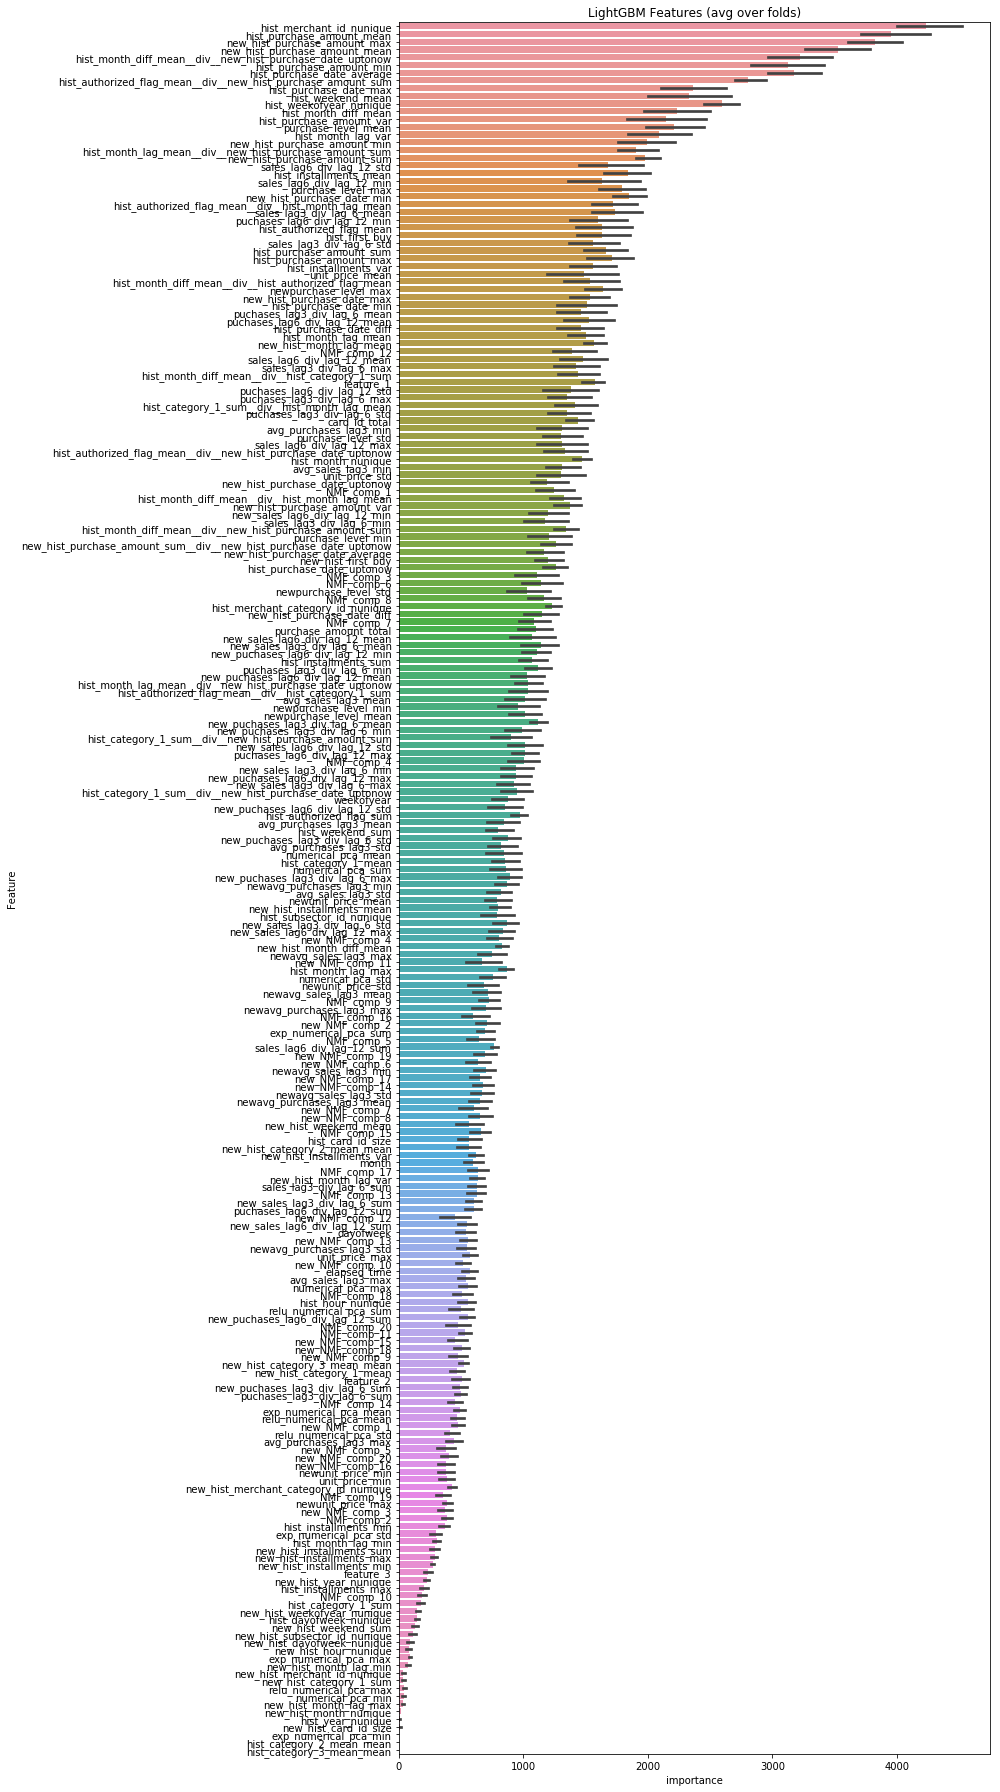

In [61]:
cols = (feature_importance_df2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df2.loc[feature_importance_df2.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [64]:
predictions

array([-2.13323427, -0.23448163, -1.00621903, ...,  0.9306894 ,
       -3.12432883,  0.09343256])

In [65]:
predictions2

array([-0.54371103, -0.24292679, -0.41665706, ...,  1.15778824,
       -0.87487808,  0.04397952])

In [74]:
final_prediction = 1.25 * predictions - 0. * predictions2

In [75]:
# import optuna

# def objective(trial):
#     train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.25, random_state=4590)
#     dtrain = lgb.Dataset(train_x, label=train_y)

#     num_round = trial.suggest_int('num_round', 1, 1000)
#     param = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'bagging_seed':11, 'random_state':4590,
#              'boosting_type': trial.suggest_categorical('boosting', ['gbdt']),
#              'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1e-1),
#              'min_data_in_leaf': 30,
#              'min_child_samples': trial.suggest_loguniform('min_child_samples', 10, 1000),
#              'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 1.0),
#              'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 1.0),
#              }

#     gbm = lgb.train(param, dtrain, num_round)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)
#     rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
#     return rmse

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [76]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = final_prediction
sub_df.to_csv("./output/submission_model20181214.csv", index=False)